In [49]:
#Bibliotecas para a cria√ß√£o do modelo
import tensorflow as tf
from tensorflow import keras

#Metricas que ser√£o ultilizadas no treinamento do modelo para a sua avalia√ß√£o
from tensorflow.keras.metrics import Precision, Recall

#Visualiza√ß√£o de dados
import matplotlib.pyplot as plt


Diret√≥rios dos arquivos de treino e teste

In [50]:
df_train_dir = "C:\\Users\\rianf\\Downloads\\chest_xray\\train"
df_test_dir = "C:\\Users\\rianf\\Downloads\\chest_xray\\test"
#"C:\Users\rianf\Downloads\chest_xray"

Agora irei analisar como est√° a distribui√ß√£o das imagens!

In [51]:
import os

normal_dir = os.path.join(df_train_dir, "NORMAL")
pneumonia_dir = os.path.join(df_train_dir, "PNEUMONIA")

num_normal = len(os.listdir(normal_dir))
num_pneumonia = len(os.listdir(pneumonia_dir))

print(f"NORMAL: {num_normal}")
print(f"PNEUMONIA: {num_pneumonia}")



NORMAL: 3432
PNEUMONIA: 3432


Agora irei armazenar os dados em treino, valida√ß√£o e teste

In [52]:
#Treino
df_train = keras.utils.image_dataset_from_directory(
    df_train_dir,
    validation_split=0.2, #Deixa 20% para valida√ß√£o
    subset="training",
    seed=123,#Garante que os dados de valida√ß√£o v√£o ser diferentes dos dados de treino
    image_size=(150, 150),
    batch_size=32,
    label_mode="binary"
)


#Valida√ß√£o
df_val = keras.utils.image_dataset_from_directory(
    df_train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(150, 150),
    batch_size=32,
    label_mode="binary"
)

#Teste
df_test = keras.utils.image_dataset_from_directory(
    df_test_dir,
    image_size = (150, 150),
    batch_size= 32,
    label_mode= "binary",
    shuffle = True,
)

Found 6864 files belonging to 2 classes.
Using 5492 files for training.
Found 6864 files belonging to 2 classes.
Using 1372 files for validation.
Found 620 files belonging to 2 classes.


In [53]:
df_train.class_names

['NORMAL', 'PNEUMONIA']

Agora que j√° armazenei as imagens em dataset, agora irei analisar se realmente deu certo olhando o conteudo dentro deles.

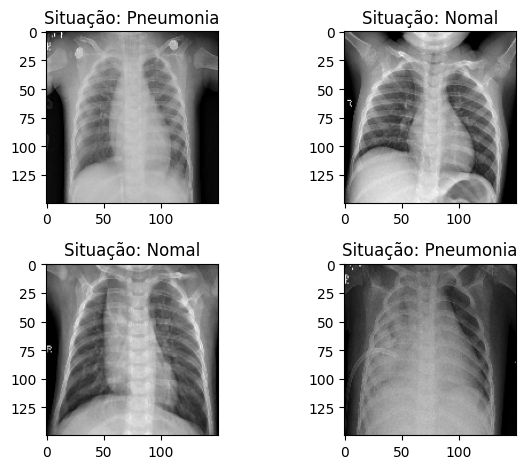

In [54]:
fig, axs = plt.subplots(2,2)
axs = axs.flatten()

for imagem, label in df_train.take(1):
    for i in range(4):
        axs[i].imshow(imagem[i].numpy().astype("uint8"))
        axs[i].set_title(f"Situa√ß√£o: {'Nomal' if label[i].numpy()==0 else 'Pneumonia'}")

plt.tight_layout()
plt.show()

Agora que tenho certeza que as imagens foram armazenadas corretamente, irie passar para o processo de escalar as imagens para ficarem em um range de 0 √† 1

In [55]:
def escalarImagem(imagem, label):
    imagem = imagem / 255
    return imagem, label 

In [56]:
df_train = df_train.map(escalarImagem)
df_test = df_test.map(escalarImagem)


In [57]:
for imagem, label in df_train.take(1):
    print(imagem)

tf.Tensor(
[[[[0.28640524 0.28640524 0.28640524]
   [0.29843137 0.29843137 0.29843137]
   [0.30653593 0.30653593 0.30653593]
   ...
   [0.4117647  0.4117647  0.4117647 ]
   [0.4120654  0.4120654  0.4120654 ]
   [0.3998563  0.3998563  0.3998563 ]]

  [[0.28613073 0.28613073 0.28613073]
   [0.29843137 0.29843137 0.29843137]
   [0.30653593 0.30653593 0.30653593]
   ...
   [0.4117647  0.4117647  0.4117647 ]
   [0.4076863  0.4076863  0.4076863 ]
   [0.38754258 0.38754258 0.38754258]]

  [[0.2820414  0.2820414  0.2820414 ]
   [0.2980196  0.2980196  0.2980196 ]
   [0.3069172  0.3069172  0.3069172 ]
   ...
   [0.41138345 0.41138345 0.41138345]
   [0.3995229  0.3995229  0.3995229 ]
   [0.3766014  0.3766014  0.3766014 ]]

  ...

  [[0.23150326 0.23150326 0.23150326]
   [0.25137255 0.25137255 0.25137255]
   [0.31284314 0.31284314 0.31284314]
   ...
   [0.35463122 0.35463122 0.35463122]
   [0.27960792 0.27960792 0.27960792]
   [0.24758205 0.24758205 0.24758205]]

  [[0.23150326 0.23150326 0.231503

Feito isso, agora irei fazer o modelo que ser√° utilizado na API. 

#### Este modelo √© uma rede neural convolucional (CNN) constru√≠da com Keras para classificar imagens de raio-X de t√≥rax e identificar se o paciente apresenta ou n√£o sinais de pneumonia.

A arquitetura do modelo inclui:

- Camadas Conv2D e MaxPooling2D para extra√ß√£o de caracter√≠sticas das imagens;

- Camada Flatten para transformar os dados em vetor;

- Camada Dense para aprendizado das rela√ß√µes;

- Camada de sa√≠da com fun√ß√£o de ativa√ß√£o sigmoid, adequada para classifica√ß√£o bin√°ria (pneumonia ou n√£o).

O modelo √© compilado com o otimizador Adam, fun√ß√£o de perda binary_crossentropy e m√©tricas:
accuracy, precision e recall.

O treinamento √© feito por 5 √©pocas, utilizando df_train como dados de treino e df_val como valida√ß√£o.

In [58]:


modelo = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid")
])


# Adicione estas m√©tricas ao compilar o modelo
modelo.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

history = modelo.fit(df_train, validation_data=df_val, epochs=5, batch_size=32)

Epoch 1/5
172/172 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 53s 285ms/step - accuracy: 0.6194 - loss: 0.6069 - precision: 0.6664 - recall: 0.4418 - val_accuracy: 0.7573 - val_loss: 60.9361 - val_precision: 0.9891 - val_recall: 0.5239
Epoch 2/5
172/172 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 51s 294ms/step - accuracy: 0.9015 - loss: 0.2520 - precision: 0.9134 - recall: 0.8844 - val_accuracy: 0.9169 - val_loss: 31.9647 - val_precision: 0.9391 - val_recall: 0.8929
Epoch 3/5
172/172 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 52s 298ms/step - accuracy: 0.9109 - loss: 0.2114 - precision: 0.9045 - recall: 0.9163 - val_accuracy: 0.9308 - val_loss: 26.6228 - val_precision: 0.9627 - val_recall: 0.8973
Epoch 4/5
172/172 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 49s 284ms/step - accuracy: 0.9255 - loss: 0.1912 - precision: 0.9257 - recall: 0.9244 - val_accuracy: 0.9169 - val_loss: 24.3350 - val_precision: 0.9722 - val_rec

In [59]:
modelo.evaluate(df_test)

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 81ms/step - accuracy: 0.9489 - loss: 0.1559 - precision: 0.9673 - recall: 0.9542


[0.1741810142993927,
 0.9419354796409607,
 0.9557291865348816,
 0.9507771730422974]



###  Descri√ß√£o da sa√≠da do modelo

Ap√≥s o treinamento, o modelo apresentou os seguintes resultados na base de valida√ß√£o:

* **Loss (binary\_crossentropy):** `0.1559`
  ‚Üí Indica que o erro m√©dio do modelo na classifica√ß√£o foi baixo.

* **Acur√°cia:** `94,89%`
  ‚Üí O modelo acertou aproximadamente 93% das classifica√ß√µes.

* **Precis√£o (Precision):** `96,73%`
  ‚Üí Dos casos em que o modelo previu **pneumonia**, cerca de 96% realmente tinham pneumonia.

* **Recall (Sensibilidade):** `95,42%`
  ‚Üí O modelo conseguiu identificar corretamente 95% dos casos que realmente tinham pneumonia.


### Interpreta√ß√£o

Esses resultados indicam que o modelo tem **alto desempenho na detec√ß√£o de pneumonia**, com destaque para o **recall elevado**, o que √© essencial em diagn√≥sticos m√©dicos (melhor errar por excesso de alerta do que omitir um caso real).



In [63]:
history.history

{'accuracy': [0.7538237571716309,
  0.9142388701438904,
  0.9213401079177856,
  0.9322651028633118,
  0.9386380314826965],
 'loss': [0.46666041016578674,
  0.22321827709674835,
  0.19659721851348877,
  0.17229321599006653,
  0.15800748765468597],
 'precision': [0.8190169930458069,
  0.9163609743118286,
  0.9181455969810486,
  0.9305707216262817,
  0.9380466341972351],
 'recall': [0.6504925489425659,
  0.9113461971282959,
  0.9248449206352234,
  0.9339656829833984,
  0.9390733242034912],
 'val_accuracy': [0.7572886347770691,
  0.9169096350669861,
  0.930757999420166,
  0.9169096350669861,
  0.9190962314605713],
 'val_loss': [60.9361457824707,
  31.964733123779297,
  26.622793197631836,
  24.334989547729492,
  23.306781768798828],
 'val_precision': [0.9890710115432739,
  0.9391171932220459,
  0.9627329111099243,
  0.972176730632782,
  0.9769737124443054],
 'val_recall': [0.5238784551620483,
  0.8929088115692139,
  0.8972503542900085,
  0.8596237301826477,
  0.8596237301826477]}

Como os dados do treino foram salvos, irei criar gr√°ficos para uma melhor visualiza√ß√£o

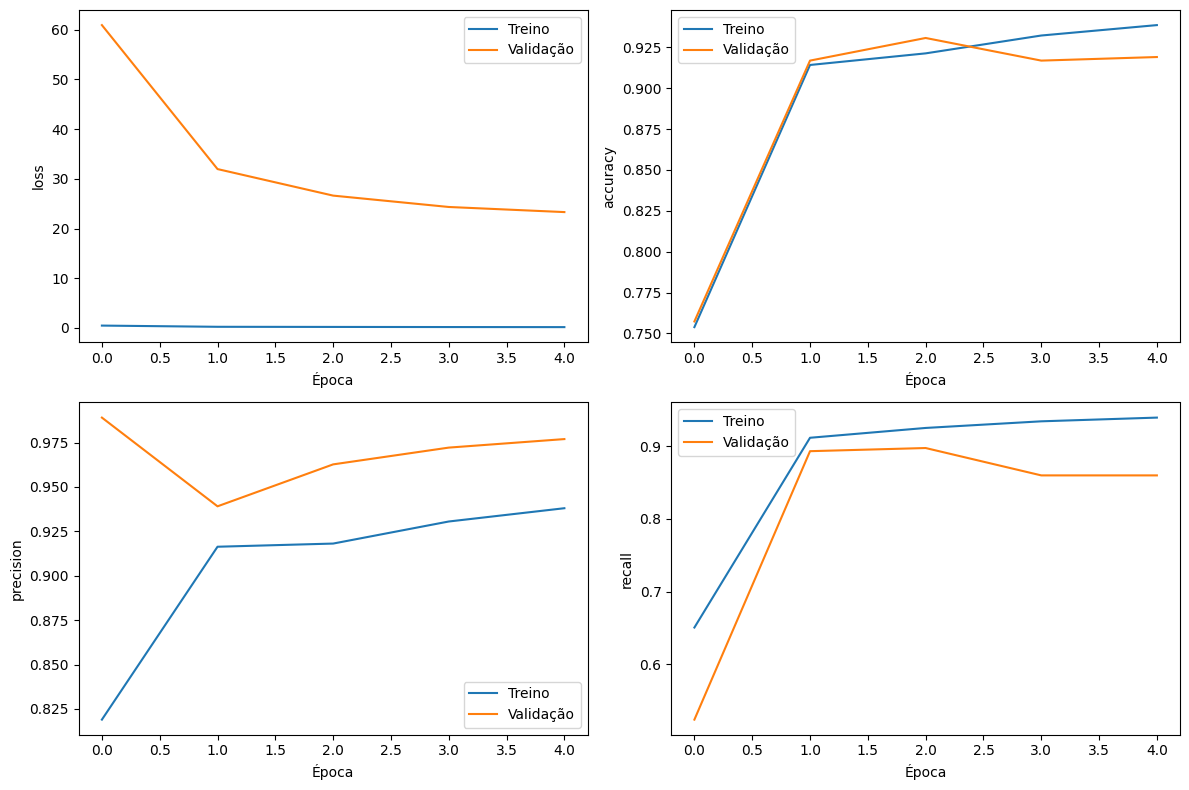

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
metrics = ['loss', 'accuracy', 'precision', 'recall']
for i, metric in enumerate(metrics):
    axs[i].plot(history.history[metric], label = "Treino")
    axs[i].plot(history.history[f"val_{metric}"], label="Valida√ß√£o")
    axs[i].set_xlabel('√âpoca')
    axs[i].set_ylabel(metric)
    axs[i].legend()

plt.tight_layout()
plt.show()



### üß† An√°lise da Evolu√ß√£o do Treinamento do Modelo

Ao observar os gr√°ficos de desempenho do modelo durante as √©pocas, nota-se uma evolu√ß√£o significativa na capacidade de generaliza√ß√£o. Na **primeira √©poca**, os resultados foram modestos: a acur√°cia e o `recall` estavam baixos, indicando que o modelo ainda n√£o conseguia distinguir bem os padr√µes de pneumonia ‚Äî o que √© comum no in√≠cio do treinamento, caracterizando um poss√≠vel **underfitting**.

A partir da **segunda √©poca**, o modelo apresentou um salto consider√°vel em todos os indicadores. A acur√°cia passou para acima de 90% e o `recall` subiu de **44% para 88%**, demonstrando uma melhora substancial na capacidade de detectar corretamente os casos de pneumonia.

Nos ciclos seguintes (√©pocas 3 a 5), os valores de **precis√£o e recall se mantiveram altos**, com pequenas oscila√ß√µes naturais. A precis√£o na valida√ß√£o se manteve consistentemente acima de 96%, indicando que as previs√µes positivas do modelo foram, na maioria dos casos, corretas. O `val_recall` estabilizou na casa dos 85% a 89%, mostrando que o modelo tamb√©m manteve boa sensibilidade para identificar pneumonia em dados n√£o vistos.

Mesmo com o **`val_loss` relativamente alto**, o desempenho geral √© muito positivo. Esse valor elevado pode estar relacionado √† forma como o modelo calcula a perda (crossentropy com alta confian√ßa nos erros), e **n√£o necessariamente indica baixa performance**, j√° que m√©tricas como `val_accuracy`, `val_precision` e `val_recall` s√£o fortes.

Esses resultados mostram que o modelo aprendeu a **generalizar bem** e **evita overfitting**, especialmente ap√≥s a aplica√ß√£o de t√©cnicas como **Dropout**. Agora vamos testar ele com uma imagem que ele nunca viu al√©m dos testes


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 97ms/step


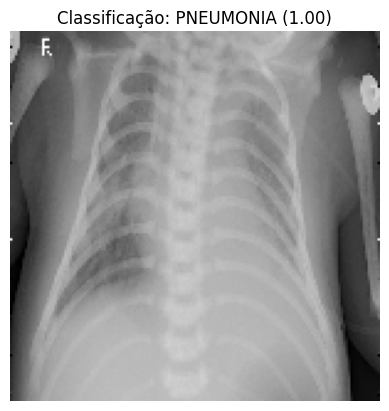

'PNEUMONIA'

In [ ]:

from tensorflow.keras.preprocessing import image


def prever_imagem(caminho_imagem, modelo):
    img = image.load_img(caminho_imagem, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Adiciona dimens√£o de batch
    img_array = img_array / 255.0  # Normaliza

    pred = modelo.predict(img_array)[0][0]

    if pred >= 0.5:
        resultado = "PNEUMONIA"
    else:
        resultado = "NORMAL"

    # Mostrar imagem com resultado
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Classifica√ß√£o: {resultado} ({pred:.2f})")
    plt.show()

    return resultado

caminho = r"C:\Users\rianf\Downloads\chest_xray\pred\PNEUMONIA\PNEUMONIA_1.jpeg" # ou .png
prever_imagem(caminho, modelo)


Ap√≥s o mini teste acima, vemos que ele acertou bem! Agora t√° na hora de colocar ele pra trabalhar! Deploy Time!!!!

In [70]:
modelo.save('App/Model/modelo_completo1.h5')